In [80]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import cioppy
import numpy as np

from shapely.wkt import loads
import shapely
from shapely.geometry import Point
from shapely.geometry import LineString

import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from ipywidgets import HTML

from geopandas import GeoDataFrame
import pandas as pd

import pytz
from datetime import datetime

from ipyleaflet import *

Download the Polarstern AIS data from https://www.sailwx.info/shiptrack/shipposition.phtml?call=DBLK at the link **Dump ship's entire track history**

Upload the file _shipdump.html_ 

In [123]:
ais_positions = 'shipdump.html'

Open the Polarstern entire track history and store all lines in a list

In [124]:
fin = open( ais_positions, "r" )
data_list = fin.readlines()
fin.close()


Remove the HTML tags (first four lines and last three lines)

In [125]:
del data_list[0:4]
del data_list[-3:]

Save the track history as a comma separated values files and then open it as a Pandas dataframe

In [126]:
f = open('polarstern.csv', 'w')
f.writelines('\n'.join(data_list))
f.close()
df = pd.read_csv('polarstern.csv')

Show the first AIS positions

In [127]:
df.head()

,UTC date/time,Unix UTC timestamp,lat,lon,callsign,wind from,knots,gust,barometer,air temp,dew point,water temp,Unnamed: 12
0,2018-Nov-08 1100,1541674822,53.567,8.55503,DBLK,NULL,NULL,NULL,NULL,NULL,NULL,NULL,NaN
1,2018-Nov-08 1030,1541673022,53.567,8.55503,DBLK,NULL,NULL,NULL,NULL,NULL,NULL,NULL,NaN
2,2018-Nov-08 1000,1541671221,53.567,8.55503,DBLK,NULL,NULL,NULL,NULL,NULL,NULL,NULL,NaN
3,2018-Nov-08 0930,1541669421,53.567,8.55503,DBLK,NULL,NULL,NULL,NULL,NULL,NULL,NULL,NaN
4,2018-Nov-08 0900,1541667622,53.567,8.55503,DBLK,NULL,NULL,NULL,NULL,NULL,NULL,NULL,NaN


Convert the 'Unix UTC timestamp' to a date/time in ISO 8061 format

In [128]:
df['Unix UTC timestamp'] = df['Unix UTC timestamp'].apply(lambda x: datetime.fromtimestamp(x).isoformat()+'Z')



Rename the column

In [129]:
df = df.rename(index=str, columns={'Unix UTC timestamp': 'ISO8061 date/time'})

Convert the field to data time to allow doing queries:

In [133]:
df['ISO8061 date/time'] = pd.to_datetime(df['ISO8061 date/time']) 

In [134]:
df.head()

,UTC date/time,ISO8061 date/time,lat,lon,callsign,wind from,knots,gust,barometer,air temp,dew point,water temp,Unnamed: 12
0,2018-Nov-08 1100,2018-11-08 12:00:22,53.567,8.55503,DBLK,NULL,NULL,NULL,NULL,NULL,NULL,NULL,NaN
1,2018-Nov-08 1030,2018-11-08 11:30:22,53.567,8.55503,DBLK,NULL,NULL,NULL,NULL,NULL,NULL,NULL,NaN
2,2018-Nov-08 1000,2018-11-08 11:00:21,53.567,8.55503,DBLK,NULL,NULL,NULL,NULL,NULL,NULL,NULL,NaN
3,2018-Nov-08 0930,2018-11-08 10:30:21,53.567,8.55503,DBLK,NULL,NULL,NULL,NULL,NULL,NULL,NULL,NaN
4,2018-Nov-08 0900,2018-11-08 10:00:22,53.567,8.55503,DBLK,NULL,NULL,NULL,NULL,NULL,NULL,NULL,NaN


Create a geo data frame including the conversion of the lat/lon columns to a geometry 

In [135]:
geometry = [Point(xy) for xy in zip(df.lon, df.lat)]
df = df.drop(['lon', 'lat'], axis=1)
crs = {'init': 'epsg:4326'}
gdf = GeoDataFrame(df, crs=crs, geometry=geometry)

In [136]:
gdf.head()

,UTC date/time,ISO8061 date/time,callsign,wind from,knots,gust,barometer,air temp,dew point,water temp,Unnamed: 12,geometry
0,2018-Nov-08 1100,2018-11-08 12:00:22,DBLK,NULL,NULL,NULL,NULL,NULL,NULL,NULL,NaN,POINT (8.55503 53.567)
1,2018-Nov-08 1030,2018-11-08 11:30:22,DBLK,NULL,NULL,NULL,NULL,NULL,NULL,NULL,NaN,POINT (8.55503 53.567)
2,2018-Nov-08 1000,2018-11-08 11:00:21,DBLK,NULL,NULL,NULL,NULL,NULL,NULL,NULL,NaN,POINT (8.55503 53.567)
3,2018-Nov-08 0930,2018-11-08 10:30:21,DBLK,NULL,NULL,NULL,NULL,NULL,NULL,NULL,NaN,POINT (8.55503 53.567)
4,2018-Nov-08 0900,2018-11-08 10:00:22,DBLK,NULL,NULL,NULL,NULL,NULL,NULL,NULL,NaN,POINT (8.55503 53.567)


Set the index on the _ISO8061 date/time_ column and create a new geo data frame for the August AIS data

In [138]:
gdf = gdf.set_index(gdf['ISO8061 date/time'])

In [139]:
august = gdf.loc['2018-08-01 01:00:00':'2018-08-31 04:00:00']

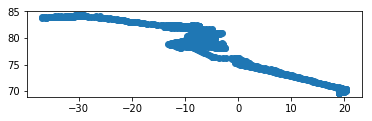

In [18]:
august.plot()

In [19]:
august.head()

,UTC date/time,ISO8061 date/time,callsign,wind from,knots,gust,barometer,air temp,dew point,water temp,Unnamed: 12,geometry
ISO8061 date/time,,,,,,,,,,,,
2018-08-31 04:00:00,2018-Aug-31 0200,2018-08-31 04:00:00,DBLK,260,9.71925,NULL,997.8,-1.4,-3.50001,-0.9,NaN,POINT (-11.1 78.8)
2018-08-31 03:00:00,2018-Aug-31 0100,2018-08-31 03:00:00,DBLK,260,11.6631,NULL,997.5,-1.29999,-3.69999,-0.500006,NaN,POINT (-10.6 78.8)
2018-08-31 02:00:00,2018-Aug-31 0000,2018-08-31 02:00:00,DBLK,270,13.60695,NULL,997,-1.00001,-3.50001,-0.100012,NaN,POINT (-10.1 78.8)
2018-08-31 01:00:00,2018-Aug-30 2300,2018-08-31 01:00:00,DBLK,280,13.60695,NULL,996.3,-0.600012,-2.29999,0.1,NaN,POINT (-9.699999999999999 78.8)
2018-08-31 00:00:00,2018-Aug-30 2200,2018-08-31 00:00:00,DBLK,290,17.49465,NULL,995.7,-0.799994,-1.9,0.200006,NaN,POINT (-9.1 78.8)


The tweet is about the Polarstern position at 2018-08-22 03:00:00:

In [141]:
wkt = gdf.loc['2018-08-22 03:00:00']['geometry'].values[0].wkt

wkt

'POINT (-35.3 83.90000000000001)'

In [143]:
toi = gdf.loc['2018-08-22 03:00:00']

toi

,UTC date/time,ISO8061 date/time,callsign,wind from,knots,gust,barometer,air temp,dew point,water temp,Unnamed: 12,geometry
ISO8061 date/time,,,,,,,,,,,,
2018-08-22 03:00:00,2018-Aug-22 0100,2018-08-22 03:00:00,DBLK,260,3.8877,NULL,1005.9,-2.19999,-2.69999,-0.299994,NaN,POINT (-35.3 83.90000000000001)


start_time = toi['ISO8061 date/time'].values[0] - np.timedelta64(1, 'h')
stop_time = toi['ISO8061 date/time'].values[0]

str(start_time)

stop_time

In [26]:
#august.apply(get_s1_reference, axis=1)

Convert the Polarstern AIS positions on 2018-08-22 03:00:00 to a line:

In [144]:
LineString(list(gdf.loc['2018-08-22']['geometry'].values)).wkt

'LINESTRING (-36.9 83.8, -36.2 83.8, -35.5 83.90000000000001, -34.8 83.90000000000001, -34 83.90000000000001, -33.3 84, -32.6 84, -31.9 84, -31.1 84, -30.3 84.09999999999999, -29.6 84.09999999999999, -28.8 84.09999999999999, -28.7 84.09999999999999, -30.2 84.09999999999999, -31.2 84, -32.1 84, -33 84, -33.8 84, -34.4 83.90000000000001, -35.3 83.90000000000001, -36.1 83.90000000000001, -36.9 83.90000000000001, -36.6 83.90000000000001)'

In [29]:
august.iloc[1]

UTC date/time           2018-Aug-31 0100
ISO8061 date/time    2018-08-31 03:00:00
callsign                            DBLK
wind from                            260
knots                            11.6631
gust                                NULL
barometer                          997.5
air temp                        -1.29999
dew point                       -3.69999
water temp                     -0.500006
Unnamed: 12                          NaN
geometry              POINT (-10.6 78.8)
Name: 2018-08-31 03:00:00, dtype: object

In [30]:
gdf.loc['2018-08-22 03:00:00']['geometry'].values[0].wkt

'POINT (-35.3 83.90000000000001)'

In [31]:
result = get_s1_reference(gdf.loc['2018-08-22 03:00:00'])

In [32]:
ciop.copy(urls=result['enclosure'], extract=False, target='/data2')

'/data2/S1B_EW_GRDM_1SDH_20180822T181427_20180822T181532_012379_016D29_884F.zip'

In [33]:
geom = LineString(list(gdf.loc['2018-08-22']['geometry'].values)).wkt
start_time = '2018-08-22T00:00:00Z'
stop_time = '2018-08-22T23:59:59Z'

In [34]:
search_params = dict([('geom', geom),
                          ('start', start_time),
                          ('stop', stop_time),
                          ('pt', 'GRD')])

In [35]:
series = 'https://catalog.terradue.com/sentinel1/search'

search = ciop.search(end_point=series, 
                     params=search_params,
                     output_fields='identifier,enclosure,self,startdate,track,wkt',
                     model='EOP')

In [25]:
ciop = cioppy.Cioppy()

def get_s1_reference(row):

    start_time = str(row['ISO8061 date/time'].values[0] - np.timedelta64(1, 'D'))
    stop_time = str(row['ISO8061 date/time'].values[0] + np.timedelta64(1, 'D'))
    wkt = row['geometry'].values[0].wkt
    
    search_params = dict([('geom', wkt),
                          ('start', start_time),
                          ('stop', stop_time),
                          ('pt', 'GRD')])
    
    series = 'https://catalog.terradue.com/sentinel1/search'
    try:
        search = ciop.search(end_point=series, 
                         params=search_params,
                         output_fields='identifier,enclosure,self,startdate,track,wkt',
                         model='EOP')
    except:
        return 'N/A'
    
    return search[0]

In [36]:
search

[{'enclosure': 'https://store.terradue.com/download/sentinel1/files/v1/S1B_EW_GRDM_1SDH_20180822T181427_20180822T181532_012379_016D29_884F',
  'identifier': 'S1B_EW_GRDM_1SDH_20180822T181427_20180822T181532_012379_016D29_884F',
  'self': 'https://catalog.terradue.com/sentinel1/search?format=atom&uid=S1B_EW_GRDM_1SDH_20180822T181427_20180822T181532_012379_016D29_884F',
  'startdate': '2018-08-22T18:14:27.7380000Z',
  'track': '103',
  'wkt': 'POLYGON((-74.846138 83.508232,-53.257969 86.788544,-25.491175 83.603851,-49.016209 81.451057,-74.846138 83.508232))'},
 {'enclosure': 'https://store.terradue.com/download/sentinel1/files/v1/S1B_EW_GRDM_1SDH_20180822T163558_20180822T163631_012378_016D22_F131',
  'identifier': 'S1B_EW_GRDM_1SDH_20180822T163558_20180822T163631_012378_016D22_F131',
  'self': 'https://catalog.terradue.com/sentinel1/search?format=atom&uid=S1B_EW_GRDM_1SDH_20180822T163558_20180822T163631_012378_016D22_F131',
  'startdate': '2018-08-22T16:35:58.1460000Z',
  'track': '102',

In [37]:
loads(geom).centroid.x

-32.87170723402131

In [38]:
global m

from ipyleaflet import Map, Polygon

m = Map(center=(loads(geom).centroid.y, loads(geom).centroid.x), zoom=3)

m


TWFwKGJhc2VtYXA9eyd1cmwnOiAnaHR0cHM6Ly97c30udGlsZS5vcGVuc3RyZWV0bWFwLm9yZy97en0ve3h9L3t5fS5wbmcnLCAnbWF4X3pvb20nOiAxOSwgJ2F0dHJpYnV0aW9uJzogJ01hcCDigKY=


In [40]:
aoi = Polygon(
    locations=np.asarray([t[::-1] for t in list(loads(geom).coords)]).tolist(),
    color="green",
    fill_color="green"
)


#pl = Polyline(locations=m.bounds_polygon)
m += aoi

In [41]:
s1_results = GeoDataFrame(search)

In [42]:
s1_results['wkt'] = s1_results['wkt'].apply(shapely.wkt.loads)

In [43]:
s1_results

,enclosure,identifier,self,startdate,track,wkt
0,https://store.terradue.com/download/sentinel1/...,S1B_EW_GRDM_1SDH_20180822T181427_20180822T1815...,https://catalog.terradue.com/sentinel1/search?...,2018-08-22T18:14:27.7380000Z,103,"POLYGON ((-74.846138 83.50823200000001, -53.25..."
1,https://store.terradue.com/download/sentinel1/...,S1B_EW_GRDM_1SDH_20180822T163558_20180822T1636...,https://catalog.terradue.com/sentinel1/search?...,2018-08-22T16:35:58.1460000Z,102,"POLYGON ((-42.295731 83.131958, -17.552143 86...."
2,https://store.terradue.com/download/sentinel1/...,S1B_EW_GRDM_1SDH_20180822T145749_20180822T1458...,https://catalog.terradue.com/sentinel1/search?...,2018-08-22T14:57:49.7691180Z,101,"POLYGON ((-53.710899 83.771278, -66.315933 87...."
3,https://store.terradue.com/download/sentinel1/...,S1B_EW_GRDM_1SDH_20180822T131947_20180822T1320...,https://catalog.terradue.com/sentinel1/search?...,2018-08-22T13:19:47.4270000Z,100,"POLYGON ((-49.95195 82.886047, -75.41834299999..."
4,https://store.terradue.com/download/sentinel1/...,S1B_EW_GRDM_1SDH_20180822T114138_20180822T1142...,https://catalog.terradue.com/sentinel1/search?...,2018-08-22T11:41:38.6600000Z,99,"POLYGON ((-37.121357 81.783356, -61.739033 84...."


In [44]:
global layer_group 

layer_group = LayerGroup(layers=())
m.add_layer(layer_group)

def f(x):
    layer_group.clear_layers()
    m.remove_layer(layer_group)
        
    p = Polygon(locations=np.asarray([t[::-1] for t in list(list(s1_results.iloc[[x]]['wkt'])[0].exterior.coords)]).tolist(), color="red", fill_color="green")
    
    d = {'identifier': list(s1_results.iloc[[x]]['identifier'])[0], 
         'track' :list(s1_results.iloc[[x]]['track'])[0]}
    
    html_value="""
        <div>
        <ul class='list-group'>
            <li class='list-group-item'>{identifier}</li>
            <li class='list-group-item'>{track}</li>
        </ul></div>""".format(**d)
    
    
    html_widget_slave = HTML(
            value=html_value,
    placeholder='',
    description='',
    )
    
    
    
    layer_group.add_layer(p)
    p.popup = html_widget_slave
    m.add_layer(layer_group)

In [45]:
interact(f, x=widgets.IntSlider(min=0,max=len(s1_results)-1,step=1,value=0));

aW50ZXJhY3RpdmUoY2hpbGRyZW49KEludFNsaWRlcih2YWx1ZT0wLCBkZXNjcmlwdGlvbj11J3gnLCBtYXg9NCksIE91dHB1dCgpKSwgX2RvbV9jbGFzc2VzPSh1J3dpZGdldC1pbnRlcmFjdCfigKY=


In [91]:
s1_results.iloc[4]

enclosure     https://store.terradue.com/download/sentinel1/...
identifier    S1B_EW_GRDM_1SDH_20180822T114138_20180822T1142...
self          https://catalog.terradue.com/sentinel1/search?...
startdate                          2018-08-22T11:41:38.6600000Z
track                                                        99
wkt           POLYGON ((-37.121357 81.783356, -61.739033 84....
Name: 4, dtype: object

In [92]:
s1_results.iloc[4]['enclosure']

'https://store.terradue.com/download/sentinel1/files/v1/S1B_EW_GRDM_1SDH_20180822T114138_20180822T114238_012375_016D07_E770'

In [93]:
ciop.copy(urls=s1_results.iloc[4]['enclosure'], extract=False, target='/data2')

'/data2/S1B_EW_GRDM_1SDH_20180822T114138_20180822T114238_012375_016D07_E770.zip'

In [94]:
a = gdf.loc['2018-08-22 03:00:00']['geometry'].values

In [97]:
a[0].wkt


'POINT (-35.3 83.90000000000001)'

In [74]:
s1_prd = GeoDataFrame(s1_results.iloc[4]).T

In [75]:
s1_prd

,enclosure,identifier,self,startdate,track,wkt
4,https://store.terradue.com/download/sentinel1/...,S1B_EW_GRDM_1SDH_20180822T114138_20180822T1142...,https://catalog.terradue.com/sentinel1/search?...,2018-08-22T11:41:38.6600000Z,99,"POLYGON ((-37.121357 81.783356, -61.739033 84...."


In [76]:
s1_prd['local_path'] = '/data2/S1B_EW_GRDM_1SDH_20180822T114138_20180822T114238_012375_016D07_E770.zip'

In [77]:
s1_prd

,enclosure,identifier,self,startdate,track,wkt,local_path
4,https://store.terradue.com/download/sentinel1/...,S1B_EW_GRDM_1SDH_20180822T114138_20180822T1142...,https://catalog.terradue.com/sentinel1/search?...,2018-08-22T11:41:38.6600000Z,99,"POLYGON ((-37.121357 81.783356, -61.739033 84....",/data2/S1B_EW_GRDM_1SDH_20180822T114138_201808...


In [79]:
s1_prd.to_csv('s1_prd.csv')